In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from os import path
from __future__ import print_function
import random
from tqdm import tqdm

from gensim.models import Word2Vec
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, TimeDistributed, Activation
from keras.layers import LSTM, Masking, BatchNormalization, Dropout
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import regularizers
import networkx as nx
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

d = 'D:\Google_Drive\Machine_Learning\CSE847_Machine_learning\GroupProject'

D:\Programs\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# [Function] Generating partitions

In [2]:
def data_partition_generator(partition_hours, data):
    # Generating partition index
    #percentile_hour = data['hours'].describe(percentiles=[percentile])[str(int(percentile*100))+'%']
    #max_hour = data['hours'].describe()['max']
    #print('The maximum granules from the {0:.2f} percentile is {1:.0f}, out of the entire maximum of {2:.0f}.'.format(percentile, round(percentile_hour), max_hour))
    #partitions = np.array(range(partition_hours, int(round(percentile_hour))+1, partition_hours))
    
    partitions = np.array(range(partition_hours[0], partition_hours[1]+1, partition_hours[0]))
    #print(partitions)
    #print(len(partitions))
    #partition_index = list(range(0,len(partitions)))

    print('At {0:.0f}-minute granules per partition, there will be {1:.0f} partitions.'.format(granule, len(partitions)))
    data['partition'] = data['hours'].map(lambda x: np.argmax(partitions>=x)+1 if x<=max(partitions) else None)
    print('Data partition created')    
    
    # Input data for RNN with hours above the max partitions dropped
    data_RNN = pd.concat([data.select_dtypes(exclude=['object']), data.padded_wordVec], axis=1).dropna()
    partition_blocks = pd.DataFrame({})

    # Add column that will be summed (accumulate) instead of average in each partition
    col_to_be_summed = ['engagement']

    # Column that will be the same throughout the entire partition, whose value will be taken from the first engagement of that partition
    col_from_first_eng = ['label', 'padded_wordVec', 'partition']

    # Initiate partitioning
    for i, topic in enumerate(data_RNN.topics_id.unique()):
        for partition in data_RNN['partition'][data['topics_id'] == topic].unique():
            partition_n = data_RNN.loc[(data_RNN['topics_id'] == topic) & (data_RNN['partition'] == partition), :].drop(['padded_wordVec'], axis=1).mean().T
            for col in col_to_be_summed:
                partition_n[col] *= len(data_RNN.loc[(data_RNN['topics_id'] == topic) & (data_RNN['partition'] == partition), :])
            for col in col_from_first_eng:
                partition_n[col] = data_RNN.loc[(data_RNN['topics_id'] == topic) & (data_RNN['partition'] == partition), col].values[0]
            partition_n['partition_index'] = partition + i*len(partitions)
            partition_blocks = pd.concat([partition_blocks, partition_n.transpose()], axis=1)
        #if (i+1) % 50 ==0:
        #    print('{} topics done out of {} topics.'.format(i+1, len(data_RNN.topics_id.unique())))

    # Adding partition interval (time to the last existing partition)
    partition_blocks = partition_blocks.T.set_index('partition_index')
    for i, topic in enumerate(data_RNN.topics_id.unique()):
        partition_blocks.loc[partition_blocks['topics_id'] == topic, 'interval_partition']\
        = partition_blocks.loc[partition_blocks['topics_id'] == topic, 'partition'].diff().fillna(0)*partition_hours[0]    
        
    # Merging partition blocks to blank dataframe (with only topics_id and [0..0] for wordVec) to create partition dataframe with rows of 0s (except topics_id) representing blank partitions
    feature_list = partition_blocks.keys()
    partitioned_data = pd.DataFrame(0, index=range(1, len(data_RNN.topics_id.unique())*len(partitions)+1), columns=feature_list)
    partitioned_data['padded_wordVec'] = pd.Series([[0] * maxlen] * len(partitioned_data), index=range(1, len(data_RNN.topics_id.unique())*len(partitions)+1))
    partitioned_data.loc[partition_blocks.index] = partition_blocks.loc[partition_blocks.index]
    partitioned_data.topics_id = np.repeat(data_RNN.topics_id.unique(), len(partitions), axis=0)
    partitioned_data = partitioned_data.reset_index()
    
    return partitions, partitioned_data

# Model

In [3]:
def LSTM_model(stories, partitions, partitioned_data, ROC=0, text = False):
    seed = 7
    np.random.seed(seed)
    prec = []
    recall = []
    acc = []
    F1 = []    
    y_pred_prob = []
    print('Training')
    count = 0
    for train_stories_keys, test_stories_keys in kfold.split(stories, stories):
        test_stories_keys = np.sort(stories.iloc[test_stories_keys].keys())
        train_stories_keys = np.sort(stories.iloc[train_stories_keys].keys())

        test = partitioned_data[partitioned_data['topics_id'].isin(test_stories_keys)].sort_values(by=['topics_id', 'index'])
        train = partitioned_data[partitioned_data['topics_id'].isin(train_stories_keys)].sort_values(by=['topics_id', 'index'])
        
        if text == False:
            num_keys = ['interval_partition', 'engagement', 'favorite_count', 'followers_count', 'friends_count']
            X_train_1 = train.loc[:, num_keys].values
            X_train = X_train_1
            y_train = train.loc[:, 'label'].values[::len(partitions)].astype(int)

            X_test_1  = test.loc[:, num_keys].values
            X_test = X_test_1
            y_test = test.loc[:, 'label'].values[::len(partitions)].astype(int)
        
        if text == True:
            num_keys = ['interval_partition', 'engagement', 'favorite_count', 'followers_count', 'friends_count']
            X_train_1 = train.loc[:, num_keys].values
            X_train_2 = train['padded_wordVec'].values
            X_train = np.vstack([np.hstack((X_train_1[i], X_train_2[i])) for i in range(maxlen + len(X_train_2))])
            y_train = train.loc[:, 'label'].values[::len(partitions)].astype(int)

            X_test_1  = test.loc[:, num_keys].values
            X_test_2  = test['padded_wordVec'].values
            X_test = np.vstack([np.hstack((X_test_1[i], X_test_2[i])) for i in range(maxlen + len(X_test_2))])
            y_test = test.loc[:, 'label'].values[::len(partitions)].astype(int)
            
        #print('X_train has a shape of shape of {}'.format(X_train.shape))
        #print('X_test has a shape of shape of {}'.format(X_test.shape))

        # Reshape X's for a batch to represent one story with numbers of partitions
        X_train = np.reshape(X_train, (len(train_stories_keys), len(partitions), len(num_keys)))
        X_test = np.reshape(X_test, (len(test_stories_keys), len(partitions), len(num_keys)))

        #print('X_train is reshaped to {}'.format(X_train.shape))
        #print('X_test is reshaped to {}'.format(X_test.shape))
        batch_size = 32

        model = Sequential()
        model.add(TimeDistributed(Dense(512), input_shape=X_train.shape[1:])) # output shape: (nb_samples, timesteps, 862)
        model.add(Activation('tanh'))
        model.add(Masking(mask_value=0.))
        model.add(BatchNormalization())
        model.add(LSTM(X_train.shape[2], dropout=0.10, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))) # output shape: (nb_samples, timesteps, 862)
        model.add(LSTM(X_train.shape[2], return_sequences=False, kernel_regularizer=regularizers.l2(0.01))) # output shape: (nb_samples, timesteps, 862)
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics = ['acc'])
        early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='auto')
        model.fit(X_train , y_train,
                  batch_size=batch_size,
                  epochs=30,
                  validation_data=(X_test, y_test),
                  callbacks = [early_stop],
                  verbose = 0)
        #score, acc = model.evaluate(X_test, y_test,
        #                            batch_size=batch_size)
        y_pred = model.predict_classes(X_test)
        y_pred_prob.append(model.predict(X_test))
        prec.append(precision_score(y_test, np.hstack(y_pred)))
        recall.append(recall_score(y_test, np.hstack(y_pred)))
        acc.append(accuracy_score(y_test, np.hstack(y_pred)))
        F1.append(f1_score(y_test, np.hstack(y_pred)))
        count += 1
        #print('Test score:', score)
        #print('Test F1: {}, Prec: {}, Recall: {}, Acc:{}'.format(F1, prec, recall, acc))
        #print('Completed')
    
    # Average y_predicted_prob over the k-fold
    y_pred_prob = np.array([i[0:len(y_pred_prob[-1])] for i in y_pred_prob])
    y_pred_prob2 = y_pred_prob[0]
    for i, y in enumerate(y_pred_prob):
        if i > 0:
            y_pred_prob2 += y
    y_pred_prob2 = y_pred_prob2/count
    
    if ROC == 1:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = 1
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_pred_prob2[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_prob2.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])        
    return acc, prec, recall, F1, fpr, tpr, roc_auc

In [4]:
def LSTM_model2(stories, partitions, partitioned_data, ROC=0):
    seed = 42
    np.random.seed(seed)
    prec = []
    recall = []
    acc = []
    F1 = []    
    print('Training')
    for train_stories_keys, test_stories_keys in kfold.split(stories, stories):
        test_stories_keys = np.sort(stories.iloc[test_stories_keys].keys())
        train_stories_keys = np.sort(stories.iloc[train_stories_keys].keys())

        test = partitioned_data[partitioned_data['topics_id'].isin(test_stories_keys)].sort_values(by=['topics_id', 'index'])
        train = partitioned_data[partitioned_data['topics_id'].isin(train_stories_keys)].sort_values(by=['topics_id', 'index'])

        num_keys = ['interval_partition', 'engagement', 'favorite_count', 'followers_count', 'friends_count']
        X_train_1 = train.loc[:, num_keys].values
        #X_train = X_train_1
        X_train_2 = train['padded_wordVec'].values
        X_train = np.vstack([np.hstack((X_train_1[i], X_train_2[i])) for i in range(len(X_train_2))])
        y_train = train.loc[:, 'label'].values[::len(partitions)].astype(int)

        X_test_1  = test.loc[:, num_keys].values
        X_test_2  = test['padded_wordVec'].values
        #X_test = X_test_1
        X_test = np.vstack([np.hstack((X_test_1[i], X_test_2[i])) for i in range(len(X_test_2))])
        y_test = test.loc[:, 'label'].values[::len(partitions)].astype(int)

        #print('X_train has a shape of shape of {}'.format(X_train.shape))
        #print('X_test has a shape of shape of {}'.format(X_test.shape))

        # Reshape X's for a batch to represent one story with numbers of partitions
        X_train = np.reshape(X_train, (len(train_stories_keys), len(partitions), maxlen + len(num_keys)))
        X_test = np.reshape(X_test, (len(test_stories_keys), len(partitions), maxlen + len(num_keys)))

        #print('X_train is reshaped to {}'.format(X_train.shape))
        #print('X_test is reshaped to {}'.format(X_test.shape))
        batch_size = 32

        model = Sequential()
        model.add(TimeDistributed(Dense(512), input_shape=X_train.shape[1:])) # output shape: (nb_samples, timesteps, 862)
        model.add(Activation('tanh'))
        model.add(Masking(mask_value=0.))
        model.add(BatchNormalization())
        model.add(LSTM(X_train.shape[2], dropout=0.10, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))) # output shape: (nb_samples, timesteps, 862)
        model.add(LSTM(X_train.shape[2], return_sequences=False, kernel_regularizer=regularizers.l2(0.01))) # output shape: (nb_samples, timesteps, 862)
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics = ['acc'])
        early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='auto')
        model.fit(X_train , y_train,
                  batch_size=batch_size,
                  epochs=30,
                  validation_data=(X_test, y_test),
                  callbacks = [early_stop],
                  verbose = 0)
        #score, acc = model.evaluate(X_test, y_test,
        #                            batch_size=batch_size)
        y_pred = model.predict_classes(X_test)
        prec.append(precision_score(y_test, np.hstack(y_pred)))
        recall.append(recall_score(y_test, np.hstack(y_pred)))
        acc.append(accuracy_score(y_test, np.hstack(y_pred)))
        F1.append(f1_score(y_test, np.hstack(y_pred)))
        #print('Test score:', score)
        #print('Test F1: {}, Prec: {}, Recall: {}, Acc:{}'.format(F1, prec, recall, acc))
        #print('Completed')
    
    fpr = None
    tpr = None
    roc_auc = None
    if ROC == 1:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = 1
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_pred[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    
            
    return acc, prec, recall, F1, fpr, tpr, roc_auc

# Generating Data

### Loading data and minor preprocessing

In [5]:
# Load time series processed data
time_data = pd.read_pickle(path.join(d + '\\Data\\time_data'))

# Process a little more by encoding topics_id and add hours basis

#time_data['topics_id'] = time_data['topics_id'].astype('category')
#cat_columns = time_data.select_dtypes(['category']).columns
#time_data[cat_columns] = time_data[cat_columns].apply(lambda x: x.cat.codes)
time_data['label'] = time_data['label'].apply(lambda x: int(x))

time_data.head(3)

,topics_id,label,post_date,minutes,interval,engagement
0,56,0,1.450415e+09,0,0.0,1
1,56,0,1.450416e+09,12,12.0,2
2,56,0,1.450418e+09,47,35.0,3


In [6]:
# Load other data
data = pd.read_pickle(path.join(d + '\\Data\\data_processed'))
data = data.drop(['label', 'post_date', 'language'], axis = 1)

# Process a little more by encoding user_id
#data['topics_id'] = data['topics_id'].astype('category')
#cat_columns = data.select_dtypes(['category']).columns
#data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
data = data.drop(['topics_id'], axis = 1)


In [7]:
data = pd.concat([data, time_data], axis=1)

In [8]:
time_data.describe()

,topics_id,label,post_date,minutes,interval,engagement
count,212252.000000,212252.000000,2.122520e+05,2.122520e+05,2.122520e+05,212252.000000
mean,347.796313,0.257411,1.440553e+09,1.997880e+04,3.436651e+02,3560.781350
std,175.719407,0.437209,6.915765e+06,9.615806e+04,2.133681e+04,5028.992387
min,0.000000,0.000000,1.229716e+09,0.000000e+00,-2.526709e+06,1.000000
25%,234.000000,0.000000,1.434504e+09,1.257000e+03,0.000000e+00,268.000000
50%,396.000000,0.000000,1.440328e+09,4.607000e+03,1.000000e+00,1314.000000
75%,509.000000,1.000000,1.447098e+09,1.156000e+04,4.000000e+00,4838.000000
max,558.000000,1.000000,1.452753e+09,3.445469e+06,2.665083e+06,24801.000000


### Text data encoding

In [9]:
# Apply word2Vec
model = Word2Vec(data.words, min_count=1, size = 12, sg=0)
data['wordVec'] = data['words'].apply(lambda x: model.wv[x])
data['wordVec'] = data['wordVec'].apply(lambda sentence: sentence.flatten())

In [10]:
# Pad the wordvec to be the same length
maxlen = max([len(X) for X in data['wordVec']])
padded_sequences = sequence.pad_sequences(data['wordVec'].values, maxlen=maxlen)
data['padded_wordVec'] = pd.Series(list(padded_sequences)).apply(np.asarray)

In [ ]:
#texts = data['words']
#tokenizer = text.Tokenizer()
#tokenizer.fit_on_texts(texts)
#data['wordSeq'] = data['words'].apply(lambda x: tokenizer.texts_to_sequences([' '.join(x)])[0])
#vocab_size = len(tokenizer.word_counts)

In [ ]:
#print('Pad word sequences (samples x time)')
#wordSeq = data['wordSeq'].values
#maxlen = max([len(X) for X in wordSeq])
#wordSeq = np.array(sequence.pad_sequences(wordSeq, maxlen=maxlen))

# Results: F1 vs hrs in different granularity

In [142]:
seed = 7
np.random.seed(seed)

hours = np.array([ 50, 60, 80, 100])
granules = [240]
df = dict()

for granule in granules:
    
    #if granule == 240:
    #    hours = np.array([4, 8, 10, 20, 50])
        
    data['hours'] = data['minutes'].apply(lambda x: x/granule)
    partitions = hours*60/granule

    F1 = []
    F1_std = []
    acc = []
    acc_std = []
    fpr = []
    tpr = []
    roc_auc = []

    i = 0

    for partition in partitions:
        #hour = data['hours'].describe(percentiles=percentile)
        #print('At {1:.0f}-minute scale granule, this span upto {2:.2f} hours out of {3:.0f}'.format(prtile_hr, granule, hour[i+4], hour[-1]))
        partitions, partitioned_data = data_partition_generator([1, int(partition)], data)

        remove_stories = partitioned_data.topics_id[partitioned_data['label'] == 1.0].value_counts().keys().tolist()[-200:]
        partitioned_data2 = partitioned_data[~partitioned_data['topics_id'].isin(remove_stories)].reset_index()

        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        stories = partitioned_data2.topics_id.value_counts()
        test_set_fraction = 1/5
        i += 1

        acc_, prec_, recall_, F1_, fpr_, tpr_, roc_auc_ = LSTM_model(stories, partitions, partitioned_data, ROC=1)
        F1.append(np.average(F1_))
        F1_std.append(np.std(F1_))
        acc.append(np.average(acc_))
        acc_std.append(np.std(acc_))
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(roc_auc_)

    df[granule] = [F1, F1_std, acc, acc_std, fpr, tpr, roc_auc]

    with open(path.join(d + '\\ModelData\\partition_results.pickle'), 'wb') as f:
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('{} granule partition done.'.format(granule))

At 240-minute granules per partition, there will be 12 partitions.
Data partition created
Training
At 240-minute granules per partition, there will be 15 partitions.
Data partition created
Training
At 240-minute granules per partition, there will be 20 partitions.
Data partition created
Training
At 240-minute granules per partition, there will be 25 partitions.
Data partition created
Training
240 granule partition done.


In [15]:
# load saved results

with open(path.join(d + '\\ModelData\\partition_results10,30.pickle'), 'rb') as f:
    a = pickle.load(f)
    
with open(path.join(d + '\\ModelData\\partition_results60,120.pickle'), 'rb') as f:
    b = pickle.load(f)
    
with open(path.join(d + '\\ModelData\\partition_results240.pickle'), 'rb') as f:
    c = pickle.load(f)   
    
partition_results = {**a, **b, **c}

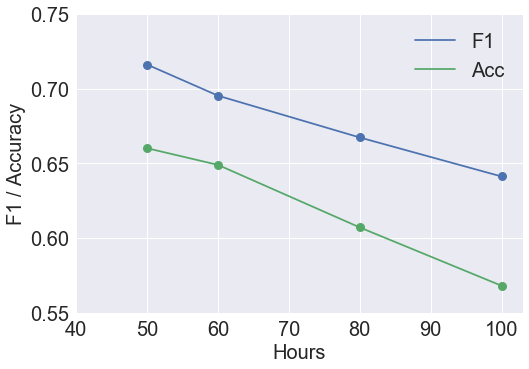

In [146]:

import seaborn as sns; sns.set(color_codes=True)
import matplotlib
#font = {'family' : 'normal',
        #'weight' : 'normal',
        #'size'   : 20}

#matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)

hours = np.array([50, 60, 80, 100])

y1 = np.array(df[240][0]) 
y2 = np.array(df[240][2])
x = list(hours)
ax = plt.scatter(x, y1, linewidths = 2)
ax = plt.plot(x, y1)
ax = plt.scatter(x, y2, linewidths = 2)
ax = plt.plot(x, y2)
plt.ylabel('F1 / Accuracy', fontsize = 20)
plt.xlabel('Hours', fontsize = 20)
plt.legend(['F1','Acc'], fontsize = 20)
plt.xticks(np.arange(40, max(hours)+1, 10.0))
plt.yticks(np.arange(0.55, 0.75+0.01, 0.05))
#plt.title('Partition = 60 minutes', fontsize = 20)
plt.show()
#plt.savefig('partition60.pdf', bbox_inches='tight', dpi=1000)

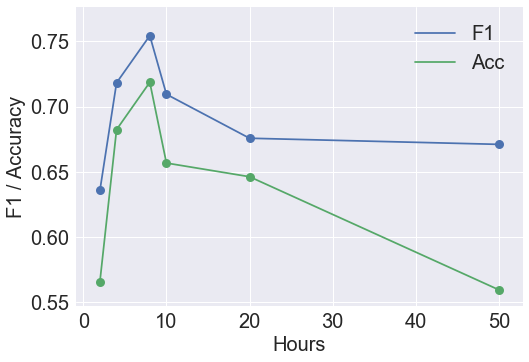

In [173]:

import seaborn as sns; sns.set(color_codes=True)
import matplotlib
#font = {'family' : 'normal',
        #'weight' : 'normal',
        #'size'   : 20}

#matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)

hours = np.array([2, 4, 8, 10, 20, 50])

y1 = np.array(parition_results[60][0]) 
y2 = np.array(parition_results[60][2])
x = list(hours)
ax = plt.scatter(x, y1, linewidths = 2)
ax = plt.plot(x, y1)
ax = plt.scatter(x, y2, linewidths = 2)
ax = plt.plot(x, y2)
plt.ylabel('F1 / Accuracy', fontsize = 20)
plt.xlabel('Hours', fontsize = 20)
plt.legend(['F1','Acc'], fontsize = 20)
plt.xticks(np.arange(0, max(hours)+1, 10.0))
plt.yticks(np.arange(0.55, 0.75+0.01, 0.05))
#plt.title('Partition = 60 minutes', fontsize = 20)
plt.show()
#plt.savefig('partition60.pdf', bbox_inches='tight', dpi=1000)

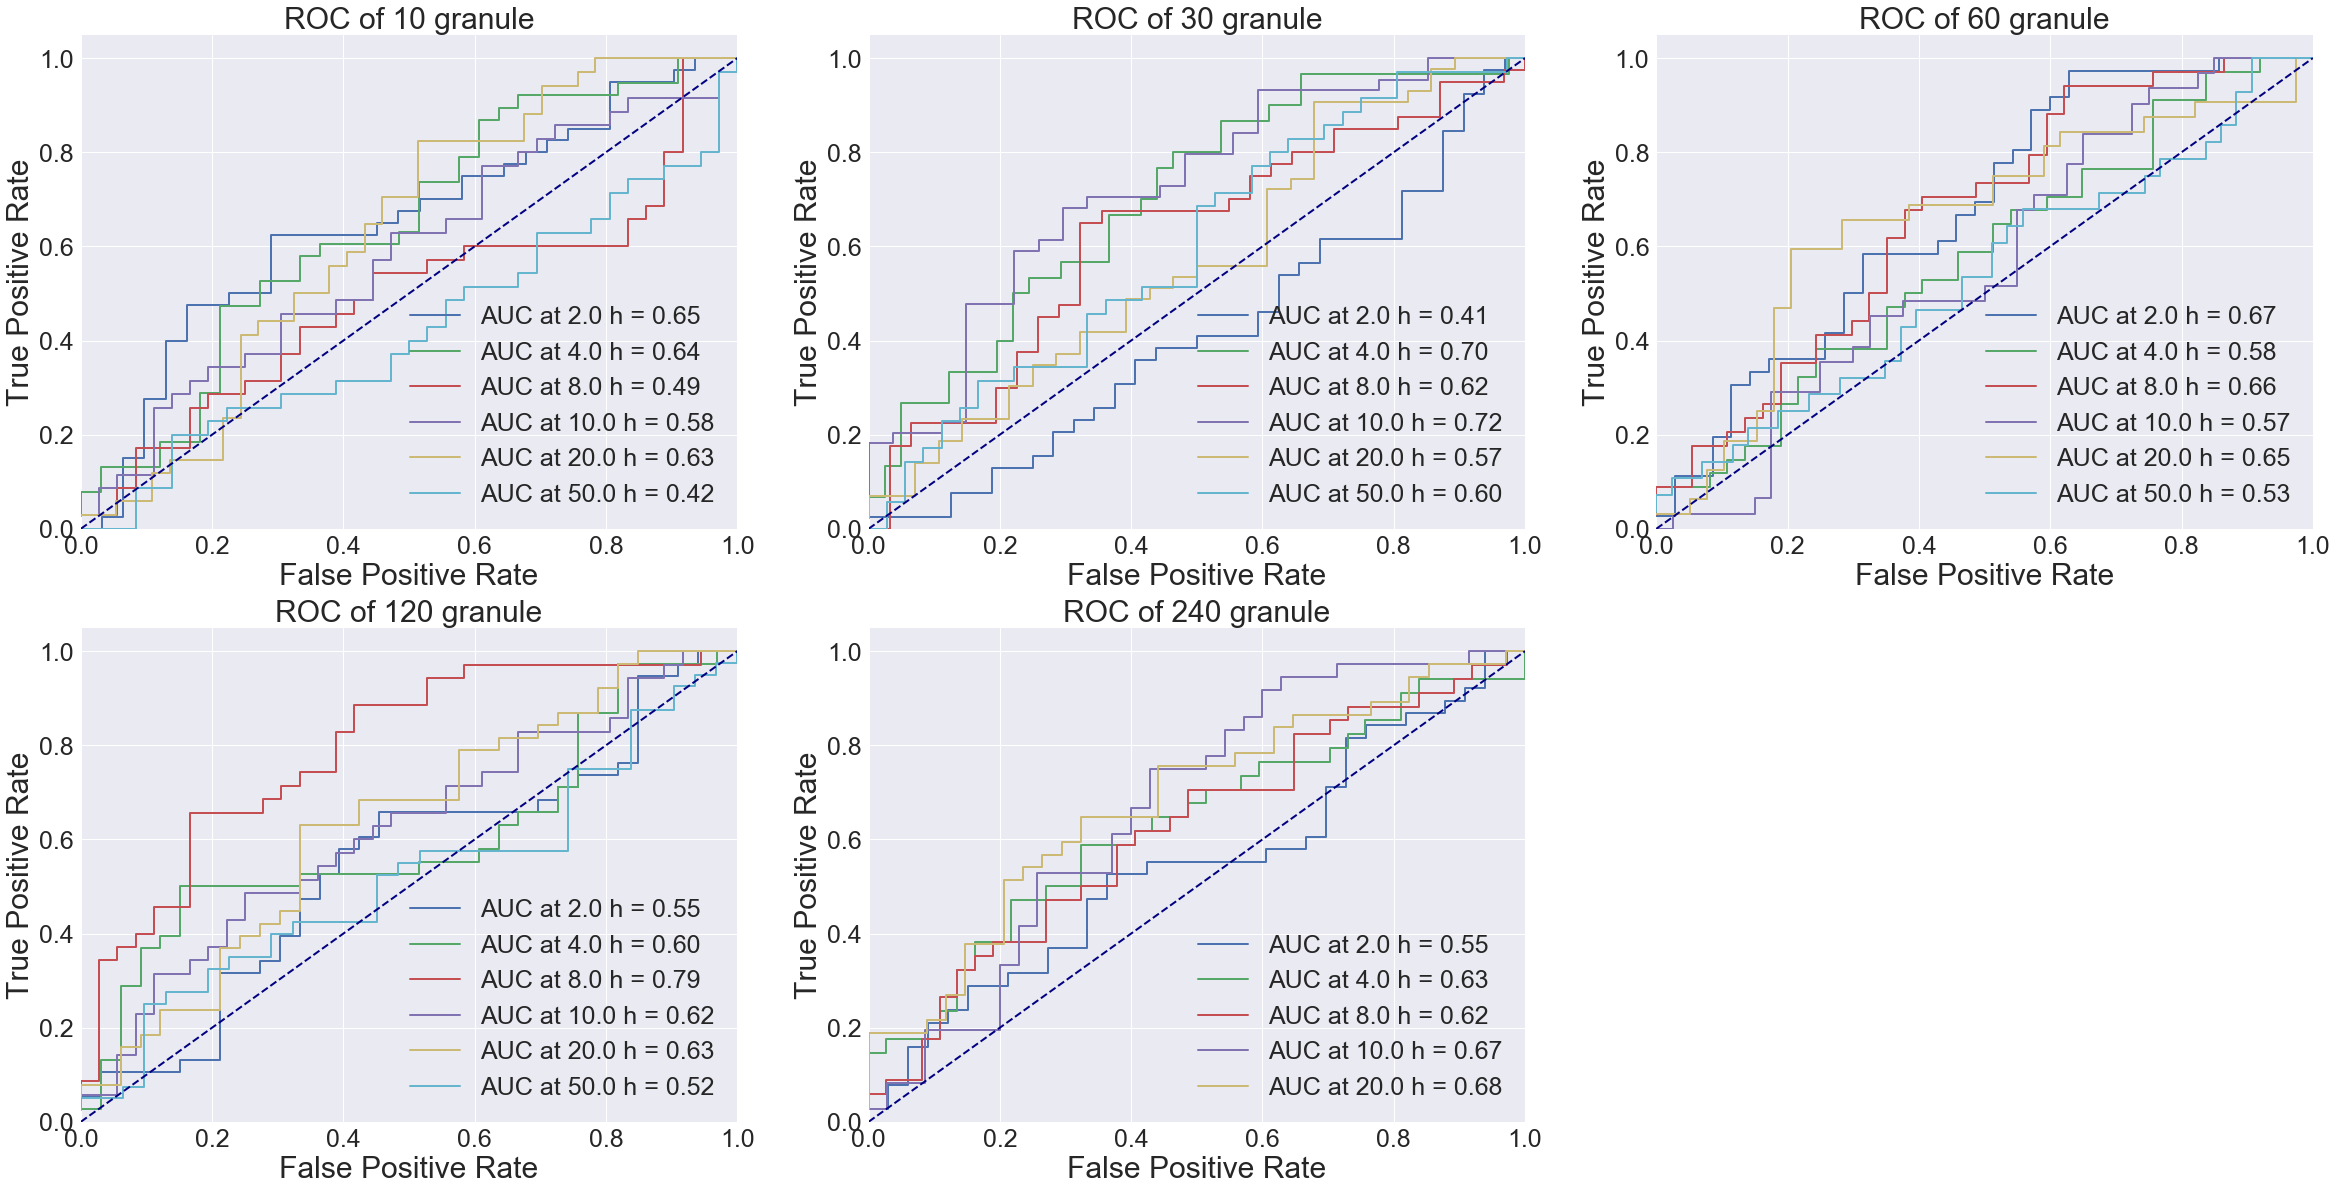

In [172]:
# Plot ROC of all results
plt.figure()
#plt.style.use('seaborn')
lw = 2
hours = np.array([2, 4, 8, 10, 20, 50])
plt.rc('xtick', labelsize=25)    
plt.rc('ytick', labelsize=25)

f = plt.figure(figsize=(10,3))
for j,result in enumerate(partition_results):
    plt.subplot(2, 3, j+1)
    for i in range(len(parition_results[result][4])):
        plt.plot(parition_results[result][4][i][0], parition_results[result][5][i][0],
             lw=lw, label='AUC at {0:0.1f} h = {1:0.2f}'.format(hours[i], parition_results[result][6][i][0]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=30)
    plt.ylabel('True Positive Rate', fontsize=30)
    plt.legend(loc="lower right", fontsize=25)
    plt.title('ROC of {} granule'.format(result), fontsize=30)
f.set_figheight(20)
f.set_figwidth(40)


plt.tight_layout
plt.show()
#plt.savefig('ROC_all.pdf', bbox_inches='tight', dpi=1000)

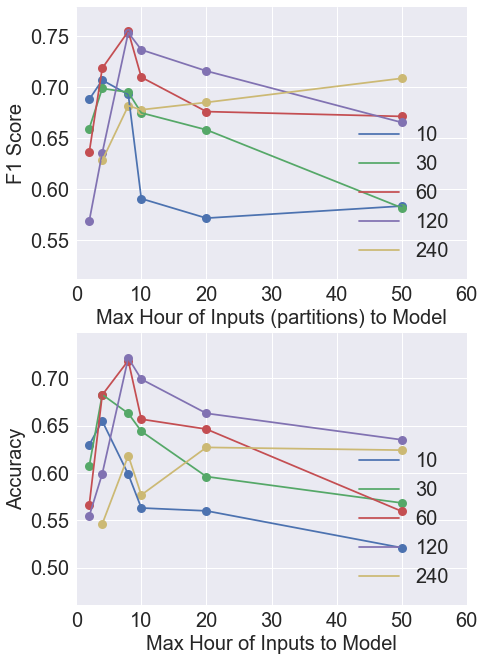

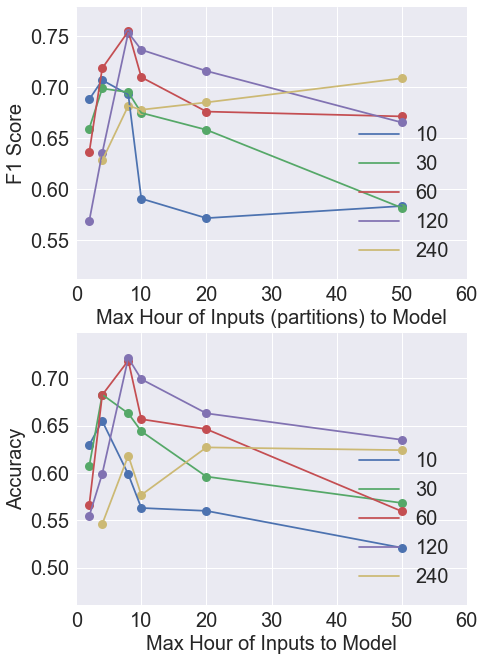

In [186]:
# Plot data for F1 of all granules
import matplotlib
plt.style.use('seaborn')
#font = {'family' : 'normal',
        #'weight' : 'normal',
        #'size'   : 20}
matplotlib.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)
hours = np.array([2, 4, 8, 10, 20, 50])
x = list(hours)
f = plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
for result in partition_results:
    #matplotlib.rc('font', **font)
    
    if result == 240:
        x = x[1:]
    
    F1_list = partition_results[result][0]
    #acc_list = [acc_30, acc_120]
    
    ax = plt.scatter(x, F1_list, linewidths = 2)
    ax = plt.plot(x, F1_list)
    
    #ax = plt.scatter(x, y2, linewidths = 2)
    #ax = plt.plot(x, y2)
plt.ylabel('F1 Score', fontsize = 20)
plt.xlabel('Max Hour of Inputs (partitions) to Model', fontsize = 20)
plt.legend(parition_results.keys(), fontsize = 20, loc="lower right")
plt.xlim([0, 60])
#plt.savefig('partition60.pdf', dpi=1200)

x = list(hours)
plt.subplot(2,1,2)
for result in partition_results:
    #matplotlib.rc('font', **font)
    
    if result == 240:
        x = x[1:]
    
    acc_list = partition_results[result][2]
    #acc_list = [acc_30, acc_120]
    
    ax = plt.scatter(x, acc_list, linewidths = 2)
    ax = plt.plot(x, acc_list)
    
    #ax = plt.scatter(x, y2, linewidths = 2)
    #ax = plt.plot(x, y2)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Max Hour of Inputs to Model', fontsize = 20)
plt.legend(parition_results.keys(), fontsize = 20, loc="lower right")
plt.xlim([0, 60])

f.set_figheight(11)
f.set_figwidth(7)
plt.show()
#plt.savefig('F1Acc_all.pdf', bbox_inches='tight', dpi=1000)

# Results: Prelim data (conditions = 10min granule, 83 partitions, 830 mins total)

In [13]:
seed = 7
np.random.seed(seed)

hours = np.array([8])
granules = [120]
df = dict()

for granule in granules:
    
    #if granule == 240:
    #    hours = np.array([4, 8, 10, 20, 50])
        
    data['hours'] = data['minutes'].apply(lambda x: x/granule)
    partitions = hours*60/granule

    F1 = []
    F1_std = []
    acc = []
    acc_std = []
    fpr = []
    tpr = []
    roc_auc = []

    i = 0

    for partition in partitions:
        #hour = data['hours'].describe(percentiles=percentile)
        #print('At {1:.0f}-minute scale granule, this span upto {2:.2f} hours out of {3:.0f}'.format(prtile_hr, granule, hour[i+4], hour[-1]))
        partitions, partitioned_data = data_partition_generator([1, int(partition)], data)

        remove_stories = partitioned_data.topics_id[partitioned_data['label'] == 1.0].value_counts().keys().tolist()[-200:]
        partitioned_data2 = partitioned_data[~partitioned_data['topics_id'].isin(remove_stories)].reset_index()

        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        stories = partitioned_data2.topics_id.value_counts()
        test_set_fraction = 1/5
        i += 1

        acc_, prec_, recall_, F1_, fpr_, tpr_, roc_auc_ = LSTM_model2(stories, partitions, partitioned_data, ROC=1)
        F1.append(np.average(F1_))
        F1_std.append(np.std(F1_))
        acc.append(np.average(acc_))
        acc_std.append(np.std(acc_))
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(roc_auc_)

    df[granule] = [F1, F1_std, acc, acc_std, fpr, tpr, roc_auc]

    with open(path.join(d + '\\ModelData\\partition_results.pickle'), 'wb') as f:
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('{} granule partition done.'.format(granule))

At 120-minute granules per partition, there will be 4 partitions.
Data partition created
Training
120 granule partition done.


In [165]:
score1 = [acc, prec, recall, F1]
score_time_and_numeric = [np.average(i) for i in score1]
score_time_and_numeric_std = [np.std(i) for i in score1]
score_time_and_numeric

[0.69954954954954951,
 0.70902048956655139,
 0.95077833253164956,
 0.8108380342314192]

In [167]:
score2 = [acc, prec, recall, F1]
score_time = [np.average(i) for i in score2]
score_time_std = [np.std(i) for i in score2]
score_time

[0.68524774774774777,
 0.69073543902529699,
 0.97945878977569123,
 0.80815880549365882]

In [171]:
score3 = [acc, prec, recall, F1]
score_time_and_text = [np.average(i) for i in score3]
score_time_and_text_std = [np.std(i) for i in score3]
score_time_and_text

[0.70849420849420852,
 0.71616490194710591,
 0.94859598672540579,
 0.81487362885103265]

In [172]:
score4 = [acc, prec, recall, F1]
score_time_and_text_and_numeric = [np.average(i) for i in score4]
score_time_and_text_and_numeric_std = [np.std(i) for i in score4]
score_time_and_text_and_numeric

[0.72274774774774764,
 0.72527912365704661,
 0.95333930814140544,
 0.82311631635008453]

# Generate Weighted Graph

In [317]:
from collections import OrderedDict

topics_id = list(OrderedDict.fromkeys(data.topics_id.values))
topics_id = [str(topic) for topic in topics_id]
article_dict = dict((topic, []) for topic in topics_id)


for topic in topics_id:
    article_dict[topic] += data['user_id'].loc[data['topics_id'] == int(topic)].tolist()



In [ ]:
import scipy.sparse as ss

max_user = max(sum([article_dict[a] for a in article_dict], []))

adj_mat =  ss.lil_matrix((max_user,max_user))

for a in tqdm(article_dict):
    i = 0
    while i < len(article_dict[a]):
        other_users = [user for user in article_dict[a] if user != article_dict[a][i]]
        for j in range(len(other_users)):
            adj_mat[article_dict[a][i]-1, other_users[j]-1] += 1
        i += 1

 48%|█████████████████▏                  | 266/559 [1:50:05<2:01:15, 24.83s/it]

In [202]:
a_dict = {'a1': [2,4], 'a2': [1,2,4,5], 'a3': [1,2], 'a4': [1,3]}

max_user = max(sum([a_dict[a] for a in a_dict], []))
adj_mat = np.zeros([max_user,max_user])

for a in a_dict:
    i = 0
    while i < len(a_dict[a]):
        other_users = [user for user in a_dict[a] if user != a_dict[a][i]]
        for j in range(len(other_users)):
            adj_mat[a_dict[a][i]-1, other_users[j]-1] += 1
        i += 1